In [1]:
# =======================
# Core
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import sys
from pathlib import Path

In [2]:
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

In [3]:
import scripts.utils as utils
from scripts.utils import (
    create_and_plot as cp,
    take_stock,
    normalize_range,
    add_temporal_features
    )



In [4]:
from scripts.preprocess import (
    datize_date, 
    numerize_value_and_volume, 
    remove_nas, 
    time_series_split, 
    preprocessor
)



In [5]:
from scripts.visualize import plot_feature_distributions, plot_stocks_closing_200MA
from scripts.create_features import fix_stock_change_pctg_leakge

In [6]:
from scripts.model import print_validation_scores, print_test_score, calibrate_and_plot



# 0. `Load the data and see summary`

`Load Dataframe`

In [7]:
FILE_PATH = os.path.join(os.getcwd(), "..", "FINAL_STOCKS.csv")

In [8]:
df = pd.read_csv(FILE_PATH)
df.tail()

,date,max_price,min_price,closing,opening,change_pctg,volume,value,n_deals,stock
16530,2014-01-15,0.80,0.79,0.79,0.80,1.27,"1,958","2,188.15",5,Wassel
16531,2014-01-14,0.79,0.79,0.80,0.79,-1.25,480,534.84,4,Wassel
16532,2014-01-12,0.80,0.80,0.82,0.80,-2.44,404,455.85,3,Wassel
16533,2014-01-08,0.82,0.82,0.81,0.82,1.23,200,231.31,2,Wassel
16534,2014-01-06,0.81,0.81,0.85,0.81,-4.71,136,155.37,1,Wassel


`Data summary`

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16535 entries, 0 to 16534
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         16535 non-null  object 
 1   max_price    16535 non-null  float64
 2   min_price    16535 non-null  float64
 3   closing      16535 non-null  float64
 4   opening      16535 non-null  float64
 5   change_pctg  16535 non-null  float64
 6   volume       16535 non-null  object 
 7   value        16535 non-null  object 
 8   n_deals      16535 non-null  int64  
 9   stock        16535 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 1.3+ MB


In [10]:
df.isna().sum()

date           0
max_price      0
min_price      0
closing        0
opening        0
change_pctg    0
volume         0
value          0
n_deals        0
stock          0
dtype: int64

In [11]:
df.describe()

,max_price,min_price,closing,opening,change_pctg,n_deals
count,16535.000000,16535.000000,16535.000000,16535.000000,16535.000000,16535.000000
mean,1.999178,1.980512,1.994600,1.994836,0.026739,8.666526
std,1.072794,1.066849,1.071422,1.071631,1.792375,11.451771
min,0.290000,0.290000,0.290000,0.290000,-47.640000,1.000000
25%,1.110000,1.100000,1.110000,1.110000,-0.540000,2.000000
50%,1.830000,1.810000,1.830000,1.830000,0.000000,5.000000
75%,2.530000,2.500000,2.520000,2.520000,0.520000,11.000000
max,7.000000,6.800000,6.840000,6.840000,31.940000,173.000000


`Reorder columns`

In [12]:
df.rename(columns={'max_price':'highest', 'min_price':'lowest'}, inplace=True)
df.columns

Index(['date', 'highest', 'lowest', 'closing', 'opening', 'change_pctg',
       'volume', 'value', 'n_deals', 'stock'],
      dtype='object')

In [13]:
desired_order = ['stock', 'date'] + [ col for col in df.columns if col not in ['stock', 'date'] ]
desired_order

['stock',
 'date',
 'highest',
 'lowest',
 'closing',
 'opening',
 'change_pctg',
 'volume',
 'value',
 'n_deals']

In [14]:
df = df[desired_order]
df.tail()

,stock,date,highest,lowest,closing,opening,change_pctg,volume,value,n_deals
16530,Wassel,2014-01-15,0.80,0.79,0.79,0.80,1.27,"1,958","2,188.15",5
16531,Wassel,2014-01-14,0.79,0.79,0.80,0.79,-1.25,480,534.84,4
16532,Wassel,2014-01-12,0.80,0.80,0.82,0.80,-2.44,404,455.85,3
16533,Wassel,2014-01-08,0.82,0.82,0.81,0.82,1.23,200,231.31,2
16534,Wassel,2014-01-06,0.81,0.81,0.85,0.81,-4.71,136,155.37,1


# `1. EDA && Feature Engineering & Preprocessing`

## 1.1 `Standard EDA and Preprocessing`

`Datize the date column`

In [15]:
df = datize_date(df)
df.dtypes

stock                  object
date           datetime64[ns]
highest               float64
lowest                float64
closing               float64
opening               float64
change_pctg           float64
volume                 object
value                  object
n_deals                 int64
dtype: object

`See which stocks ahs the largest volume and #of trades`

In [16]:
df.dtypes

stock                  object
date           datetime64[ns]
highest               float64
lowest                float64
closing               float64
opening               float64
change_pctg           float64
volume                 object
value                  object
n_deals                 int64
dtype: object

`Numerize the (value, volume) columns`

In [17]:
df = numerize_value_and_volume(df)
df[['value','volume']].dtypes

value     float64
volume    float64
dtype: object

In [18]:
df.groupby('stock')['volume'].sum().sort_values(ascending=False).head().to_frame()

,volume
stock,
BoP,233303637.0
apic,217731363.0
Isbk,113171223.0
oreedo,70735761.0
AIB,43606684.0


In [19]:
df.groupby('stock')['n_deals'].sum().sort_values(ascending=False).head().to_frame()

,n_deals
stock,
BoP,44264
apic,33722
oreedo,26076
Isbk,17927
AIB,6694


`Set stock, date as the index`

In [20]:
df.set_index('stock', inplace=True)
df.index.unique()

Index(['AIB', 'apic', 'BoP', 'bpc', 'GUI', 'Isbk', 'jph', 'oreedo', 'trust',
       'Wassel'],
      dtype='object', name='stock')

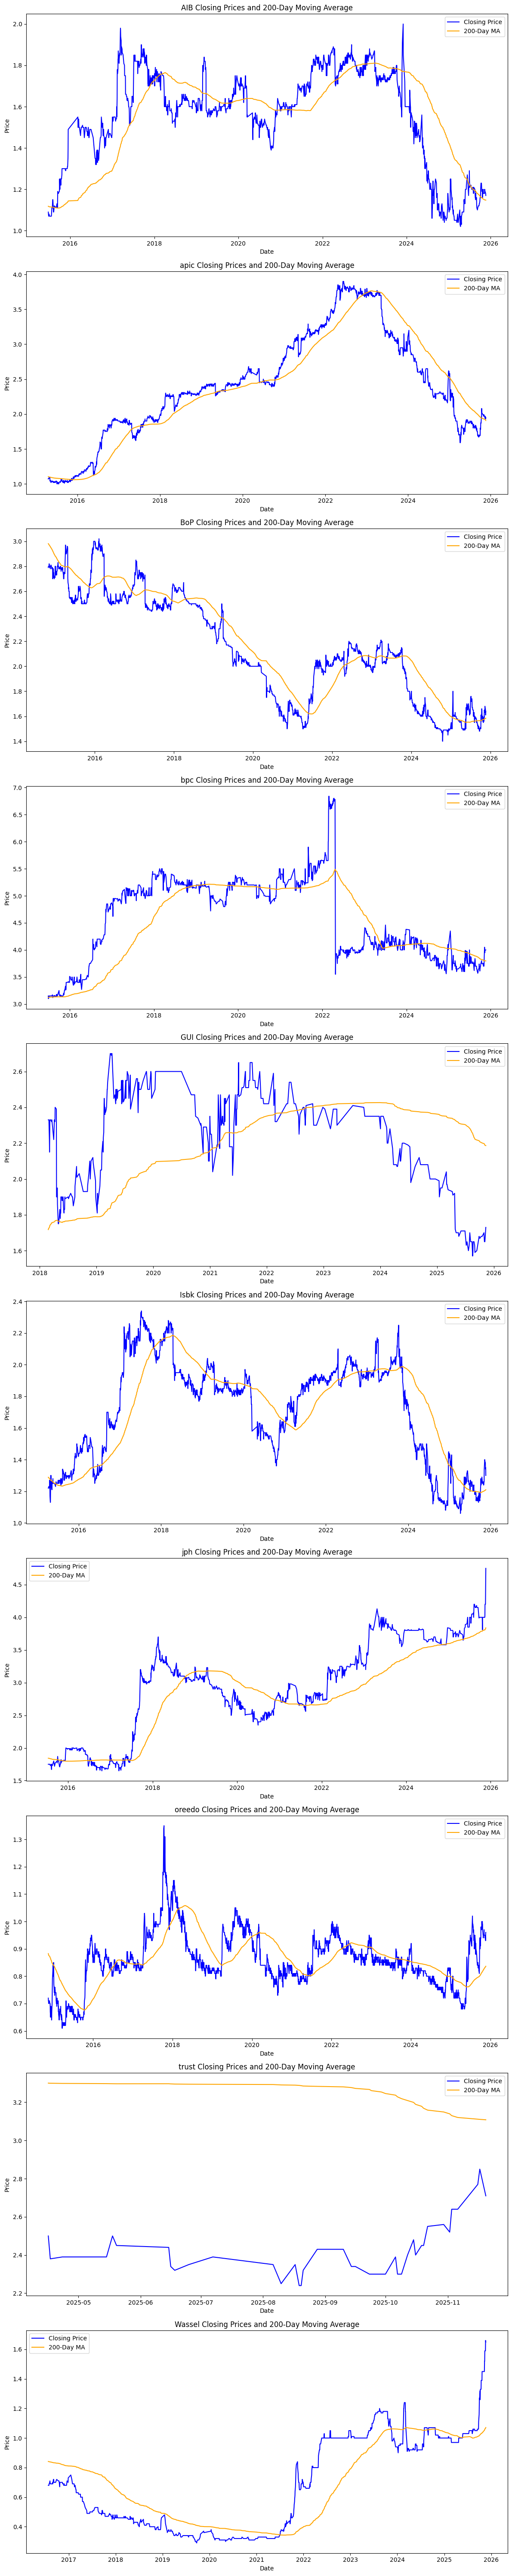

In [21]:
plot_stocks_closing_200MA(df)

`Working with individual stocks`

            highest  lowest  closing  opening  change_pctg   volume  \
date                                                                  
2014-01-02     3.20    3.19     3.20     3.19        -0.31  25566.0   
2014-01-05     3.17    3.12     3.19     3.13        -1.88  24331.0   
2014-01-06     3.15    3.12     3.13     3.13         0.00  94225.0   
2014-01-08     3.17    3.13     3.13     3.17         1.28  44673.0   
2014-01-09     3.19    3.17     3.17     3.19         0.63  29244.0   

                value  n_deals  
date                            
2014-01-02   81800.50       19  
2014-01-05   76502.03       28  
2014-01-06  295711.69       31  
2014-01-08  141304.63       19  
2014-01-09   93072.42       32  


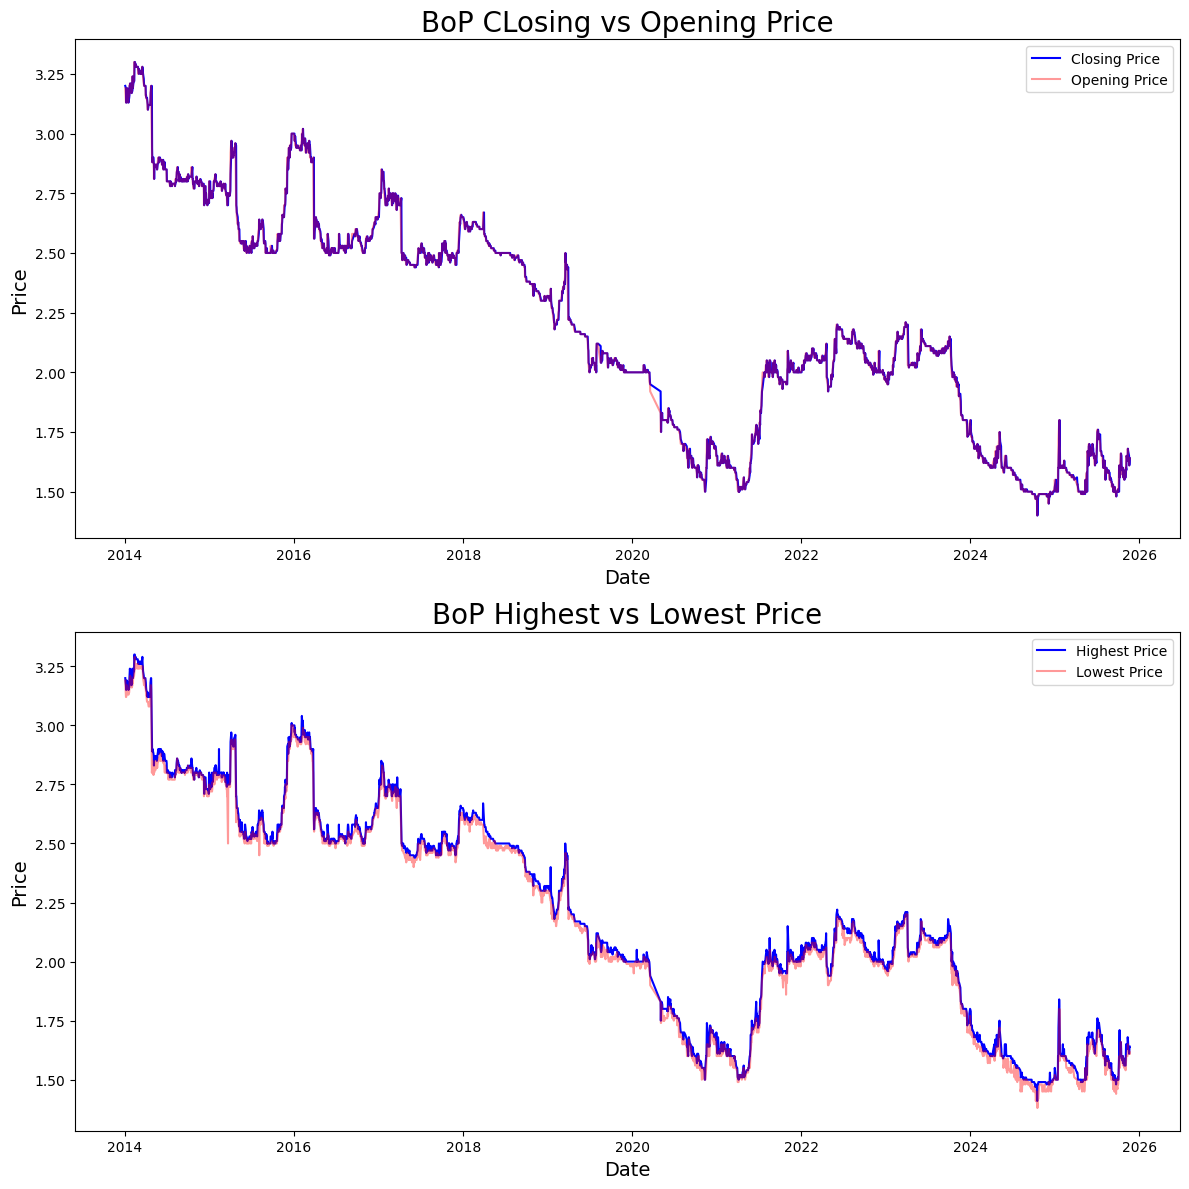

In [22]:
bop = take_stock(df, 'BoP')

`As we can see from the first graph we cacn tell that opening and closing prices are almost always identical indicating the low volatility in PEX in general`

----------------------------------

`The initial model we will try is to predict the direction of the movement for stock`

## 1.2 `Creating informative variables`

`First of all create the movemetn direction target variable`

`Create 1 Day Classification target variable with concern for predicting up movements`

### 1.2.1 `Create The Target Variable`

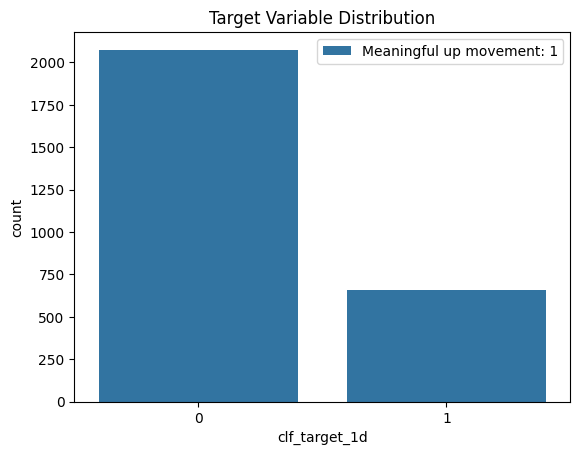

Variables with Strong Correlation with variable clf_target_1d (> 0.25) :  [('change_pctg', 0.592865615803275)]


In [23]:
bop = cp(bop, "target")

### 1.2.2 `Create Time Since Last Trade Variable`

Maximum idle time between trades is: 45 days.


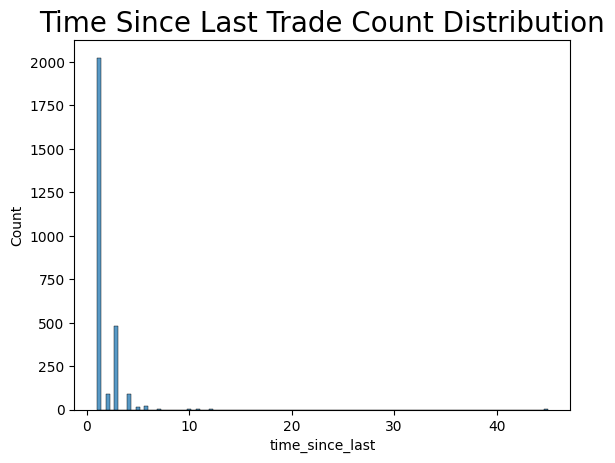

No Strong Pearson Correlations.


In [24]:
bop = cp(bop, "time_since_last")

### 1.2.3 `Create Moving Averages`

Moving Average for 20 Days Created.
Moving Average for 50 Days Created.
Moving Average for 200 Days Created.
MA Ratio Created


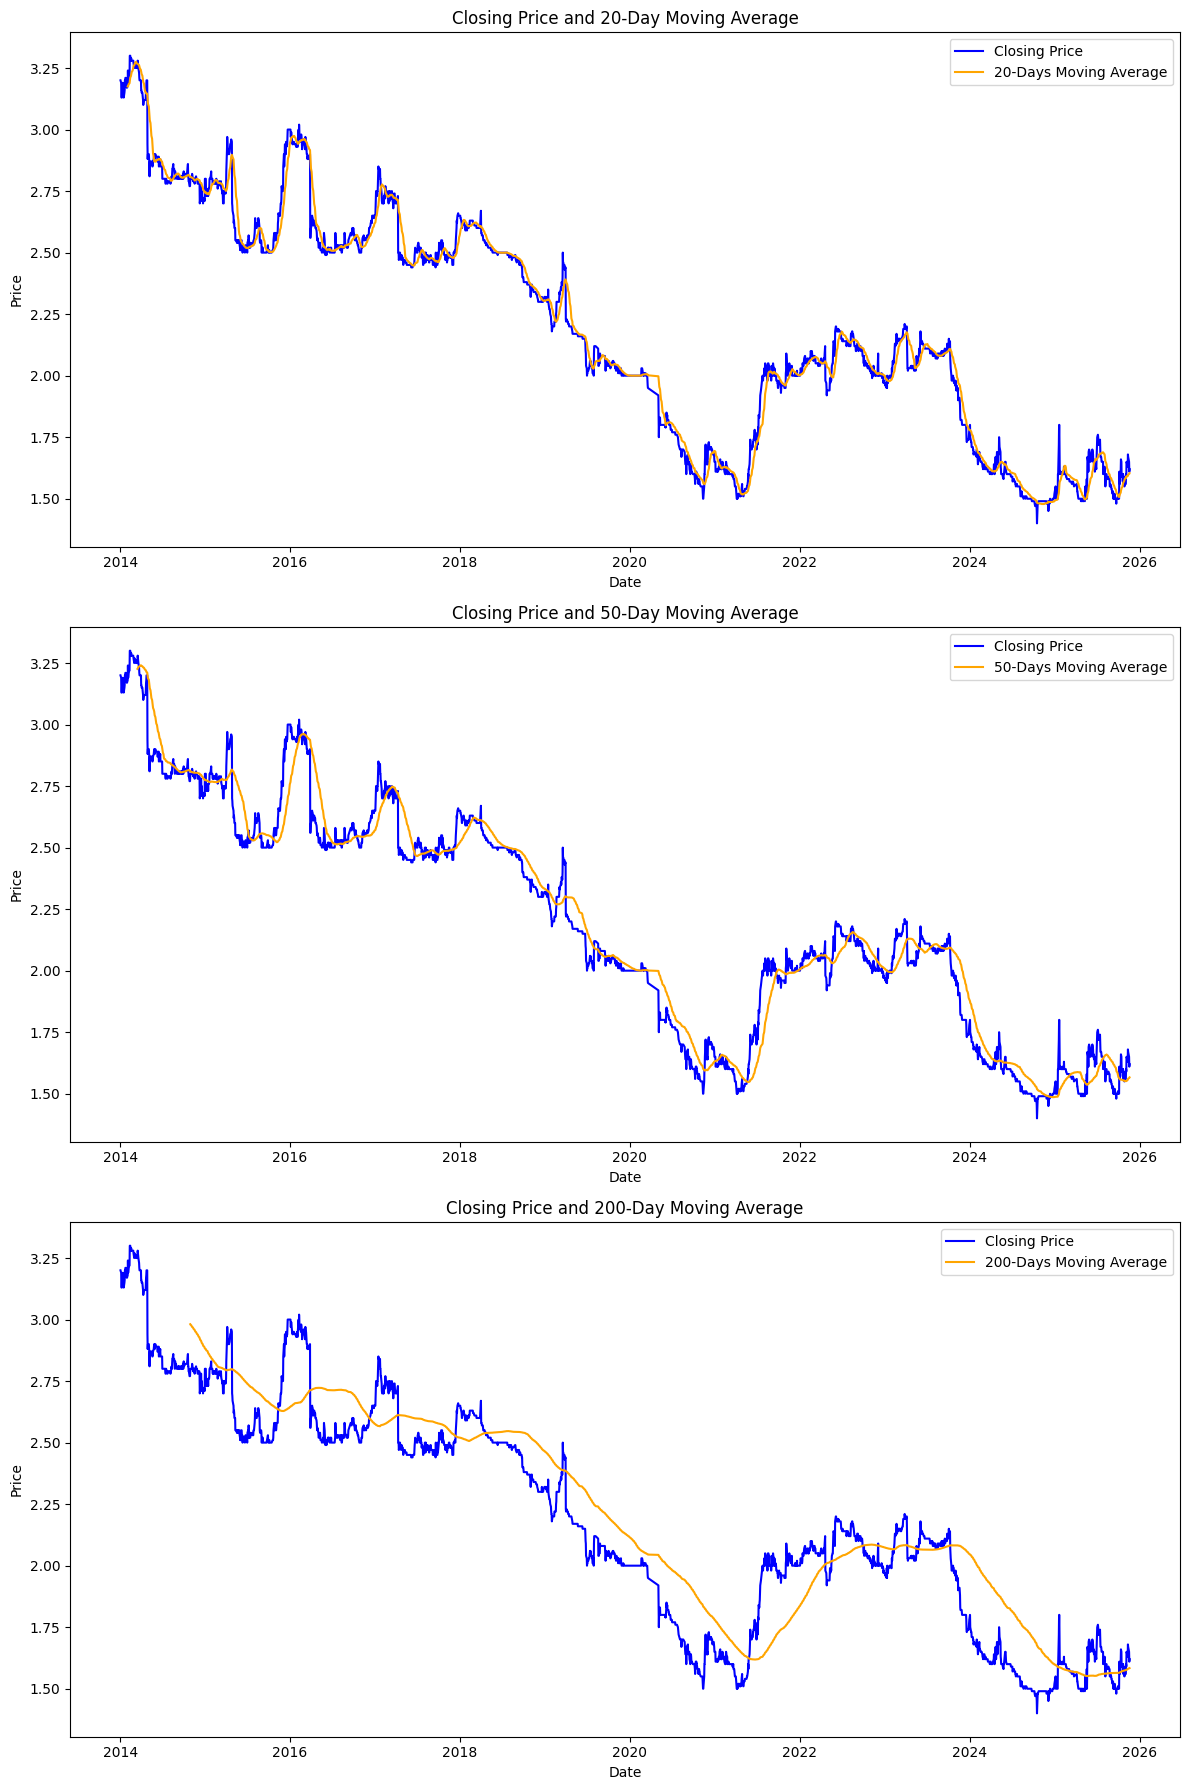

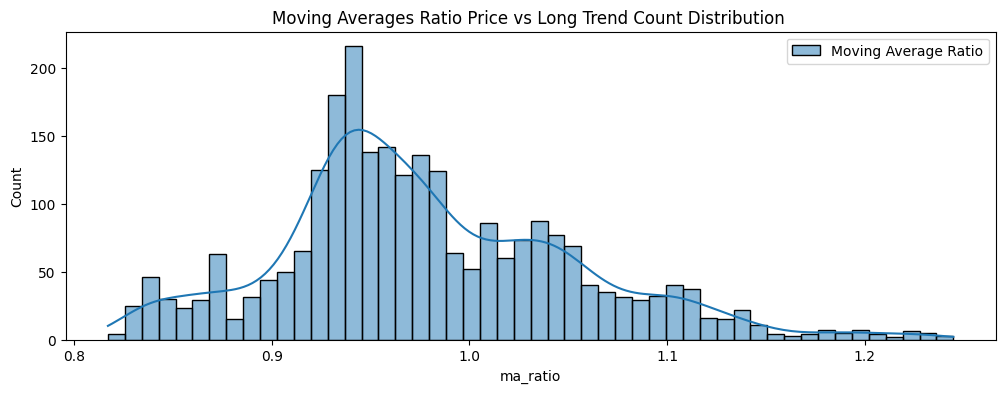

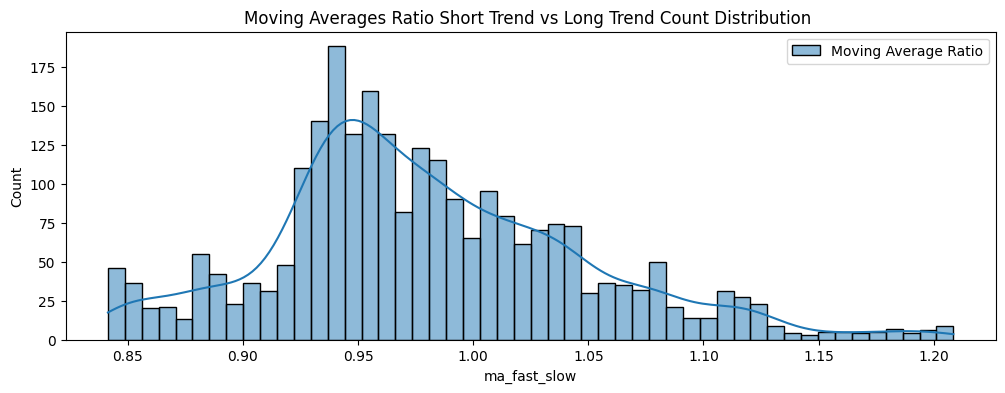

           20_MA     50_MA    200_MA
20_MA   1.000000  0.992926  0.941359
50_MA   0.992926  1.000000  0.958654
200_MA  0.941359  0.958654  1.000000
Variables with Strong Correlation with variable 20_MA (> 0.25) :  [('highest', 0.9919806150591076), ('lowest', 0.9919495385649161), ('closing', 0.9932790936145349), ('opening', 0.9921758857712485), ('n_deals', 0.2772051542715414), ('ma_fast_slow', 0.276939496177473)]


In [25]:
bop = cp(bop, "moving_averages")

`This chart makes total sense since PEX ahs very low volatility which is why even the 20MA almost perfectly hugs the closign price`

`MA won't reveal much information and alone is not enough for ML model to revela hideen patterns we need to create more features`

### 1.2.4 `Create Range Variable`

Variables with Strong Correlation with variable range (> 0.25) :  [('n_deals', 0.3970993821851938)]


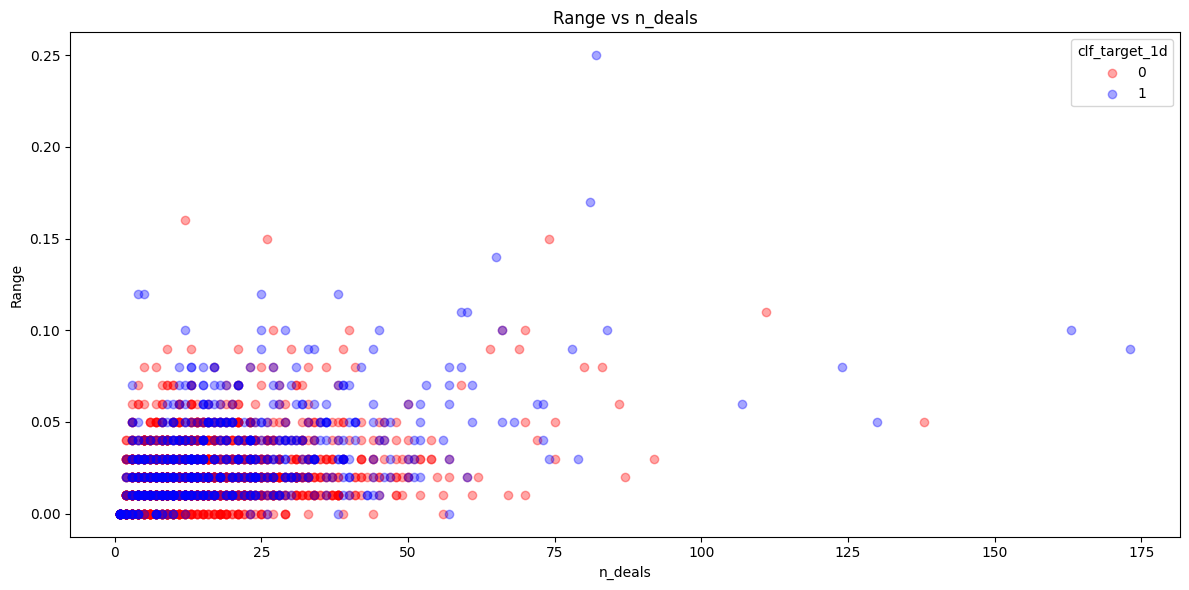

In [26]:
bop = cp(bop, "target", plot=False, corr=True)
bop = cp(bop, "range")

### 1.2.5 `Crate Daily Returns Variables`

1-Day Return Variable Created.
3-Day Return Variable Created.
5-Day Return Variable Created.


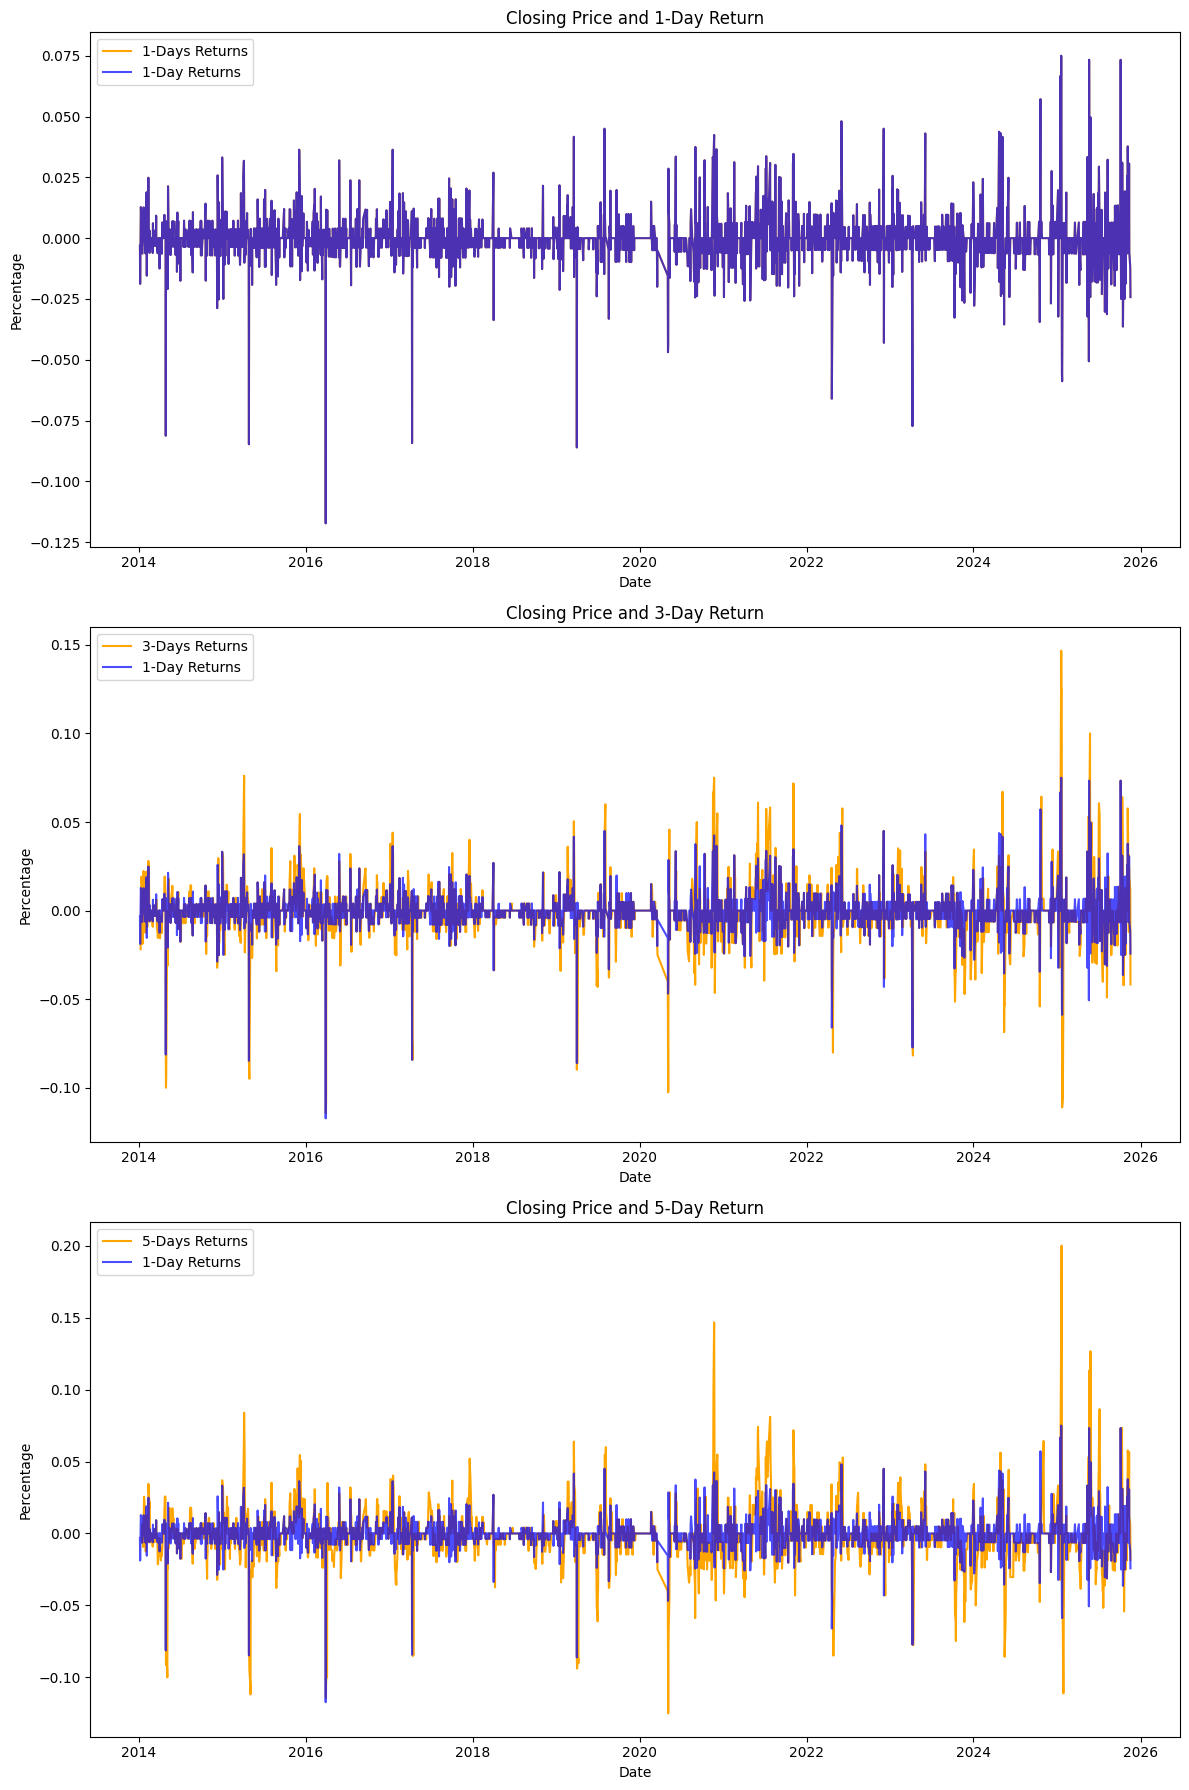

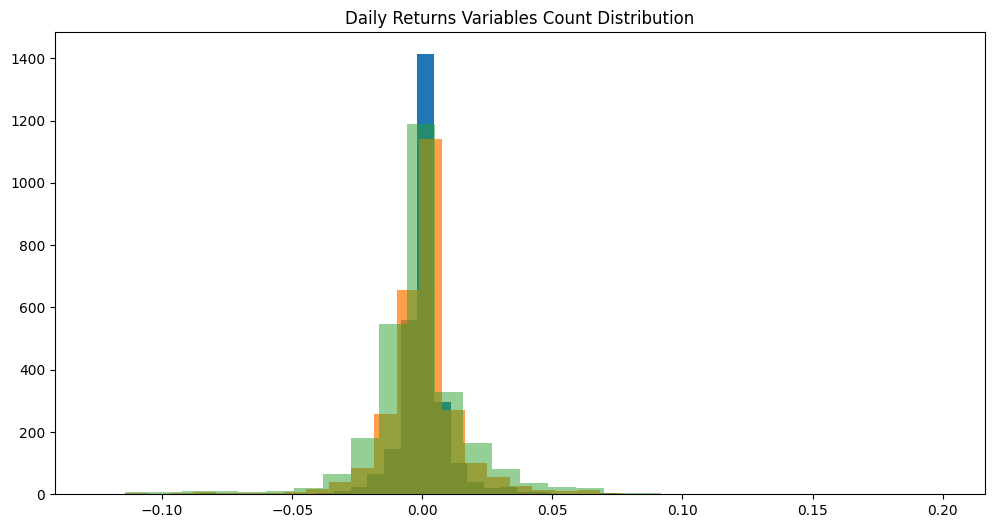

          r1        r3        r5
r1  1.000000  0.562517  0.443446
r3  0.562517  1.000000  0.761972
r5  0.443446  0.761972  1.000000
No Strong Pearson Correlations.


In [27]:
bop = cp(bop, "returns")

`As we can see the returns distibution has fatter tails on the longer run which makes total sense for a low volatility market`

### 1.2.6 `volatility X days`

10-Day Volatility Variable Created.
20-Day Volatility Variable Created.


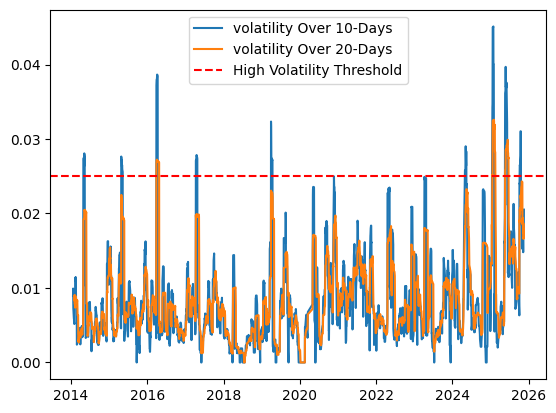

                volatility_10d  volatility_20d
volatility_10d         1.00000         0.76246
volatility_20d         0.76246         1.00000
Variables with Strong Correlation with variable volatility_10d (> 0.25) :  [('200_MA', -0.26876817282042914)]


In [28]:
bop = cp(bop, "volatility")

`For reference comparing BoP with oreedo who is riskier`

In [29]:
ord = take_stock(df, 'oreedo', plot=False)

10-Day Volatility Variable Created.
20-Day Volatility Variable Created.


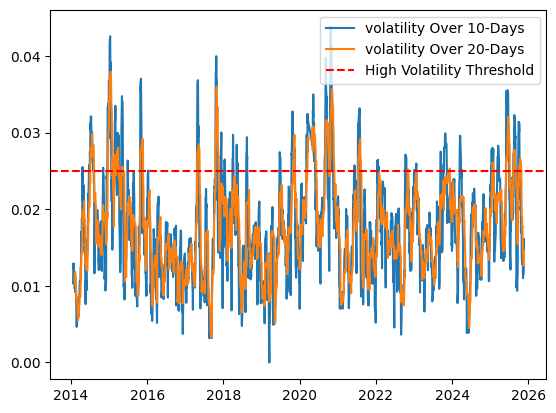

                volatility_10d  volatility_20d
volatility_10d        1.000000        0.807378
volatility_20d        0.807378        1.000000


In [30]:
ord = cp(ord, "returns", plot=False, corr=False)
ord = cp(ord, "volatility", corr=False)

### 1.2.7 `RSI`

RSI for 7- days created.
RSI for 14- days created.


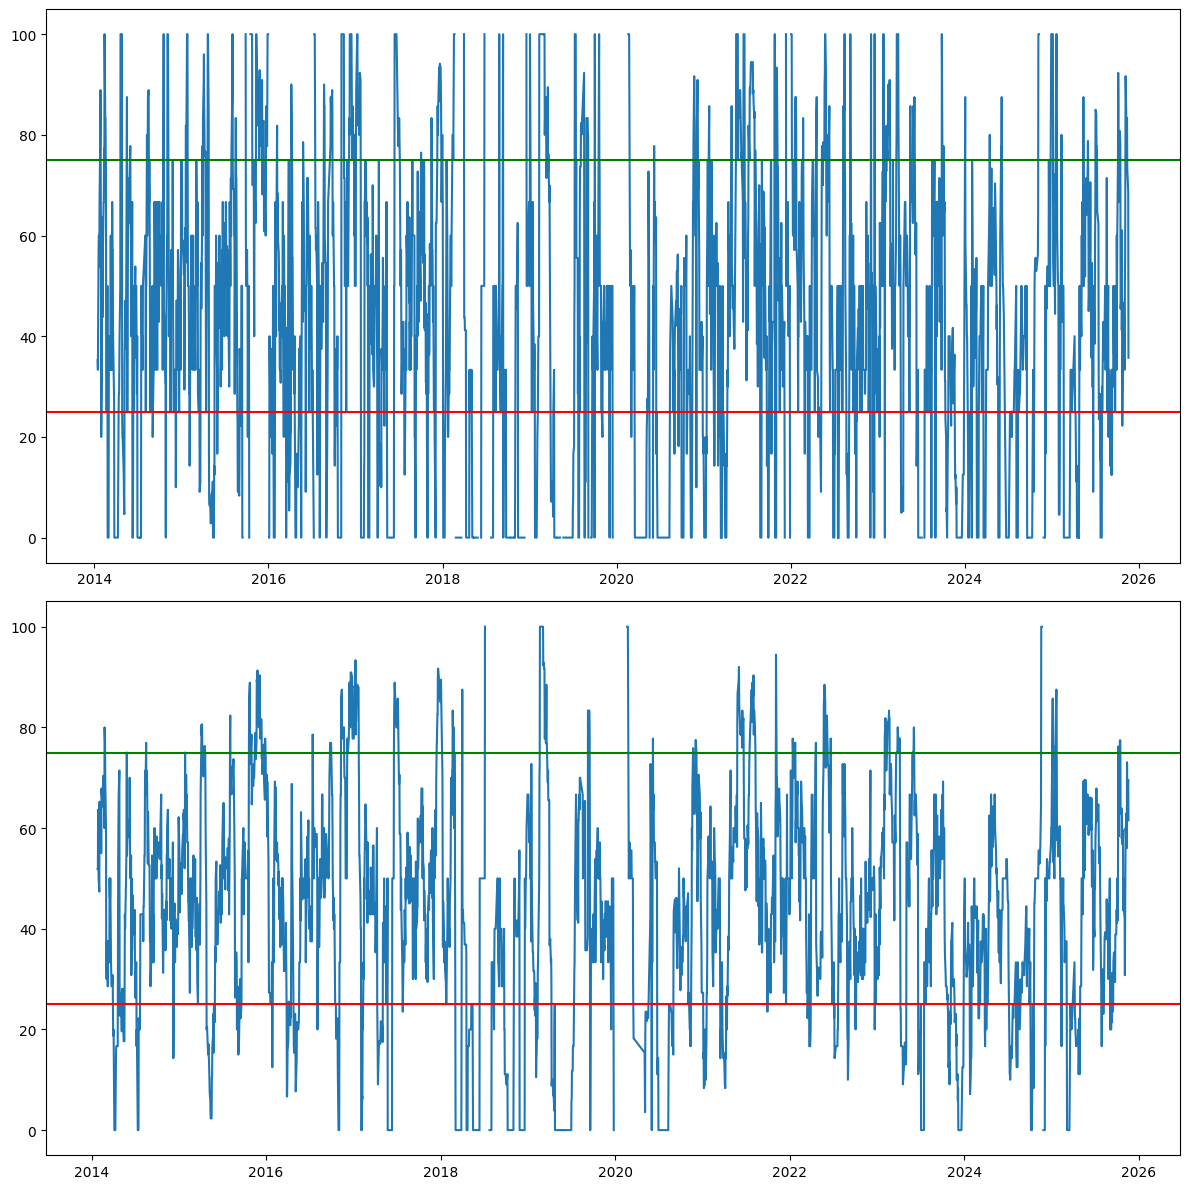

           rsi_7    rsi_14
rsi_7   1.000000  0.721209
rsi_14  0.721209  1.000000
Variables with Strong Correlation with variable rsi_7 (> 0.25) :  [('ma_ratio', 0.2885509696199181), ('r1', 0.2950910720842484), ('r3', 0.46581939398521083), ('r5', 0.5799303987555876)]


In [31]:
bop = cp(bop, "rsi", plot=True)

### 1.2.8 `Liquidity features`

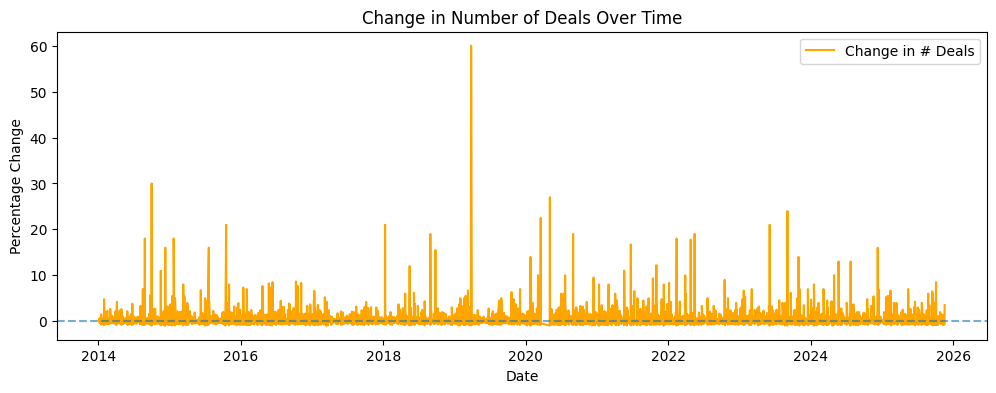

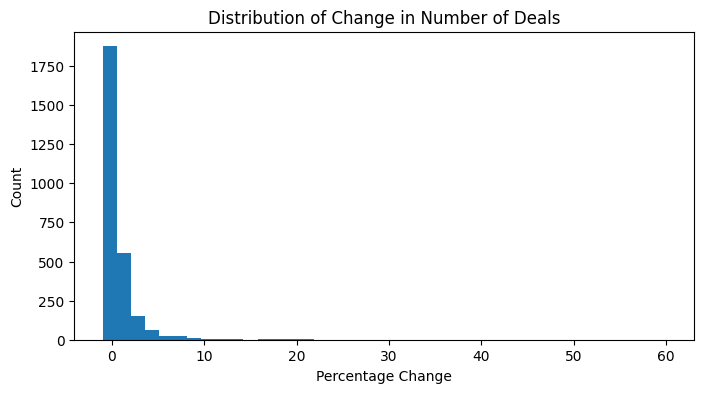

In [32]:
bop = cp(bop, "liquidity")

---------------------------------------

In [33]:
bop = normalize_range(bop)

Normalized Range Created
               range  range_norm
range       1.000000    0.945146
range_norm  0.945146    1.000000
Due to almost perfect correlation range feature dropped.


### 1.2.9 `Temporal Features`

In [34]:
bop = add_temporal_features(bop)

Temporal Features Created.


### 1.2.10 `MACD`

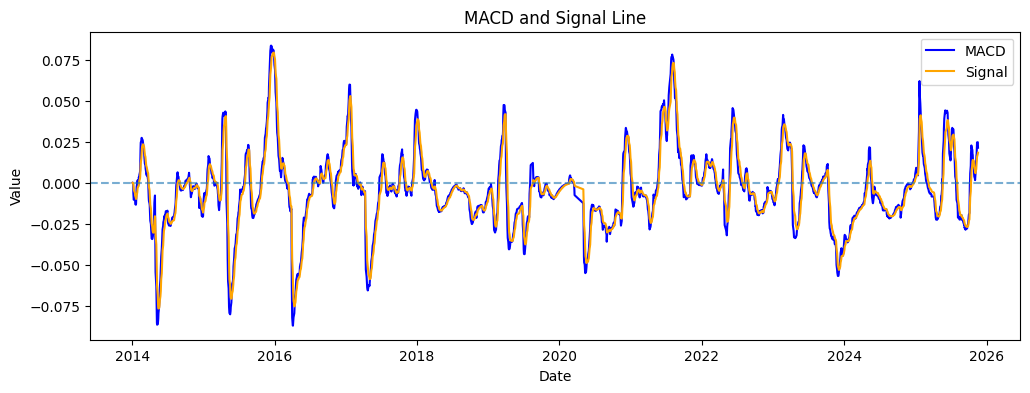

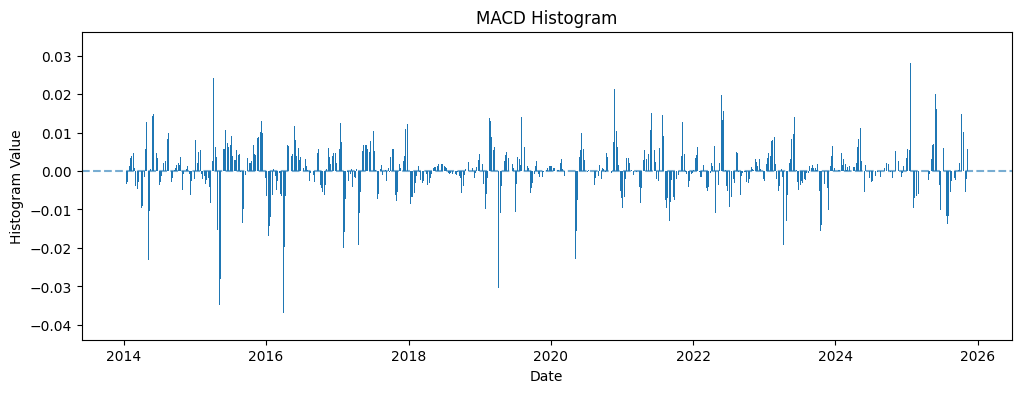

In [35]:
bop = cp(bop, "macd")

### 1.2.11 `Stochastic`

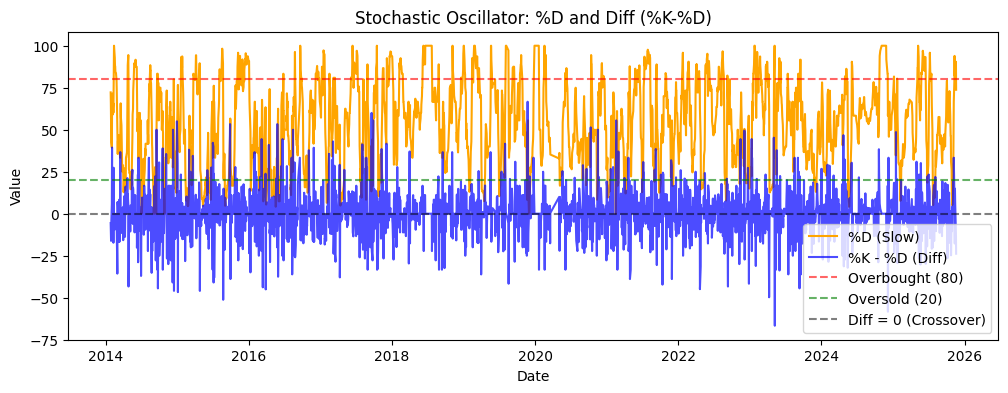

In [36]:
bop = cp(bop, "stochastic")

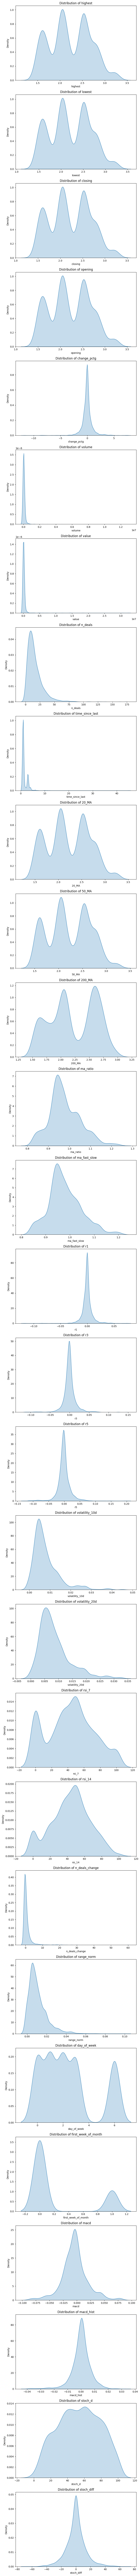

In [37]:
plot_feature_distributions(bop, target_col=None)

### 1.3.0 `After training the model we found out that there is a leakge in the data where change pctg was calculated based on tomorrow's price isntead of today's`

In [38]:
bop = fix_stock_change_pctg_leakge(bop, 'BoP')

## 1.3 `Dropping redundant/highly multi cllinearity features`

In [39]:
corr = bop.corr()
pairs = [
    (i, j, corr.loc[i, j])
    for idx, i in enumerate(corr.columns)
    for j in corr.columns[idx + 1:]
    if abs(corr.loc[i, j]) > 0.85
]
    

In [40]:
pairs

[('highest', 'lowest', np.float64(0.9990559922811156)),
 ('highest', 'closing', np.float64(0.9988500484542382)),
 ('highest', 'opening', np.float64(0.9997520280729839)),
 ('highest', '20_MA', np.float64(0.9919766078418625)),
 ('highest', '50_MA', np.float64(0.9793744803939513)),
 ('highest', '200_MA', np.float64(0.9273834950417738)),
 ('lowest', 'closing', np.float64(0.9985989395491028)),
 ('lowest', 'opening', np.float64(0.9991087628581339)),
 ('lowest', '20_MA', np.float64(0.9919458534782256)),
 ('lowest', '50_MA', np.float64(0.9793493896052592)),
 ('lowest', '200_MA', np.float64(0.9278910596394996)),
 ('closing', 'opening', np.float64(0.9988029294547078)),
 ('closing', '20_MA', np.float64(0.9932748866097996)),
 ('closing', '50_MA', np.float64(0.980956466979782)),
 ('closing', '200_MA', np.float64(0.9289191072706876)),
 ('opening', '20_MA', np.float64(0.9921722429716583)),
 ('opening', '50_MA', np.float64(0.9797622292730859)),
 ('opening', '200_MA', np.float64(0.9279692542905585)),
 

In [41]:
bop.drop(columns=['opening', 'highest', 'lowest', '20_MA', '50_MA', '200_MA', 'volume', 'value'], inplace=True)

## 1.4 `Check for  noisy, missy (either logical or physical), inconsistent, and duplicated Data.`

In [42]:
bop.duplicated().sum()

np.int64(0)

In [43]:
bop.isna().sum()

closing                  0
n_deals                  0
clf_target_1d            0
time_since_last          1
ma_ratio               199
ma_fast_slow           199
r1                       1
r3                       3
r5                       5
volatility_10d          10
volatility_20d          20
rsi_7                  160
rsi_14                  65
n_deals_change           1
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                 15
stoch_diff              15
change_pctg              1
dtype: int64

In [44]:
bop[199:].isna().sum()

closing                  0
n_deals                  0
clf_target_1d            0
time_since_last          0
ma_ratio                 0
ma_fast_slow             0
r1                       0
r3                       0
r5                       0
volatility_10d           0
volatility_20d           0
rsi_7                  152
rsi_14                  51
n_deals_change           0
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                  0
stoch_diff               0
change_pctg              0
dtype: int64

In [45]:
bop.describe()

,closing,n_deals,clf_target_1d,time_since_last,ma_ratio,ma_fast_slow,r1,r3,r5,volatility_10d,...,rsi_14,n_deals_change,range_norm,day_of_week,first_week_of_month,macd,macd_hist,stoch_d,stoch_diff,change_pctg
count,2731.000000,2731.000000,2731.000000,2730.000000,2532.000000,2532.000000,2730.000000,2728.000000,2726.000000,2721.000000,...,2666.000000,2730.000000,2731.000000,2731.000000,2731.000000,2731.000000,2731.000000,2716.000000,2716.000000,2730.000000
mean,2.226979,16.203955,0.239839,1.589011,0.978076,0.979727,-0.000199,-0.000582,-0.000966,0.008006,...,43.569757,0.655203,0.010975,2.376053,0.226657,-0.004131,0.000027,53.800206,-0.005698,-0.019860
std,0.453706,14.087994,0.427063,1.388704,0.074992,0.067853,0.010263,0.016807,0.021443,0.006523,...,22.432148,2.578209,0.010074,2.055885,0.418745,0.023988,0.006959,24.792938,13.424747,1.026326
min,1.400000,1.000000,0.000000,1.000000,0.817082,0.841376,-0.117241,-0.114187,-0.125000,0.000000,...,0.000000,-0.987500,0.000000,0.000000,0.000000,-0.087326,-0.040208,0.000000,-66.666667,-11.724138
25%,1.950000,7.000000,0.000000,1.000000,0.932092,0.937559,-0.003953,-0.006061,-0.008032,0.003931,...,28.720238,-0.437500,0.004348,1.000000,0.000000,-0.016819,-0.002816,34.722222,-6.666667,-0.395257
50%,2.150000,13.000000,0.000000,1.000000,0.964635,0.968803,0.000000,0.000000,0.000000,0.006089,...,45.000000,0.000000,0.008065,2.000000,0.000000,-0.004336,0.000381,54.516317,0.000000,0.000000
75%,2.550000,21.000000,0.000000,2.000000,1.026728,1.019913,0.000000,0.004032,0.004950,0.010112,...,58.333333,0.833333,0.014706,3.000000,0.000000,0.006060,0.003472,73.611111,6.060606,0.000000
max,3.300000,173.000000,1.000000,45.000000,1.244914,1.208514,0.075000,0.146667,0.200000,0.045107,...,100.000000,60.000000,0.100000,6.000000,1.000000,0.083739,0.032554,100.000000,66.666667,7.500000


`All of these makes total sense  except for volume_z which is a huge number for a z_score`

`The entire preprocess, feature engineering and dropping initial workflow will look like this`

`1.Datize date`

`2.Set date as index`

`3.numerize volume`

`4.Create all the default features`

`5.Drop unnecessary features`

-----------------------------------------------------------------------

# `2. Cleaning missing values (there is no noisy values)`

In [46]:
df = remove_nas(bop)

closing                  0
n_deals                  0
clf_target_1d            0
time_since_last          1
ma_ratio               199
ma_fast_slow           199
r1                       1
r3                       3
r5                       5
volatility_10d          10
volatility_20d          20
rsi_7                  160
rsi_14                  65
n_deals_change           1
range_norm               0
day_of_week              0
first_week_of_month      0
macd                     0
macd_hist                0
stoch_d                 15
stoch_diff              15
change_pctg              1
dtype: int64
Remaining Nulls 0
